# 2022 빅콘테스트_join EDA
## 우 걱정마세요

#1. 라이브러리 및 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
COLORS = sns.color_palette()

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=20).get_name() # 기본 폰트 사이즈 : 20
plt.rc('font', family=font_name)
fm._rebuild()

## 데이터 불러오기

In [4]:
join = pd.read_csv('/content/drive/MyDrive/2022_Bigcontest/Data/Preprocessing+loan.csv')

# 2. 함수

In [5]:
def plot_bar(df, xlabel, ylabel, title, color=COLORS[0], figsize=(20, 10), rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=11)
    plot.set_ylabel(ylabel, fontsize=11)
    plot.set_title(title, fontsize=13)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

# 3. ~별 대출

In [6]:
join = join.drop(['Unnamed: 0'], axis = 1)

In [7]:
join.columns

Index(['application_id', 'user_id', 'gender', 'insert_time', 'yearly_income',
       'income_type', 'employment_type', 'houseown_type', 'desired_amount',
       'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'existing_loan_cnt',
       'existing_loan_amt', 'reage', 'career', 'credit_grade',
       'loanapply_insert_time', 'bank_id', 'product_id', 'loan_limit',
       'loan_rate', 'is_applied', 'dow'],
      dtype='object')

In [8]:
column_list = join.drop(['application_id', 'user_id', 'insert_time', 'loanapply_insert_time', 'yearly_income', 'desired_amount', 'existing_loan_amt', 'loan_limit',
       'loan_rate', 'is_applied'], axis = 1)
column_list = column_list.columns

In [9]:
column_list

Index(['gender', 'income_type', 'employment_type', 'houseown_type', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'reage', 'career', 'credit_grade', 'bank_id',
       'product_id', 'dow'],
      dtype='object')

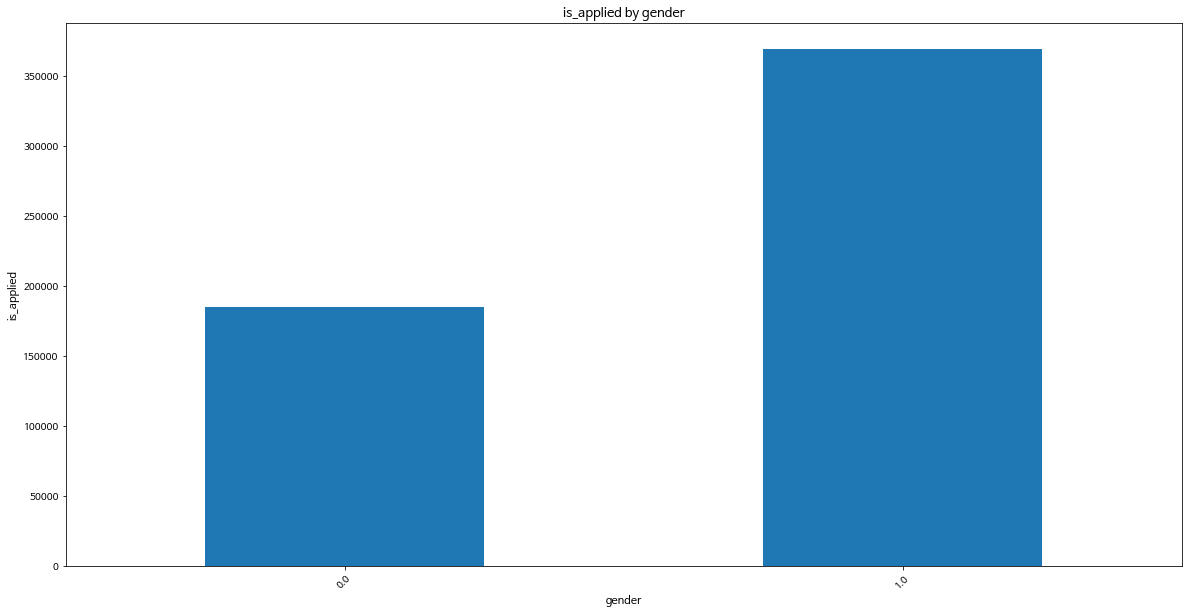

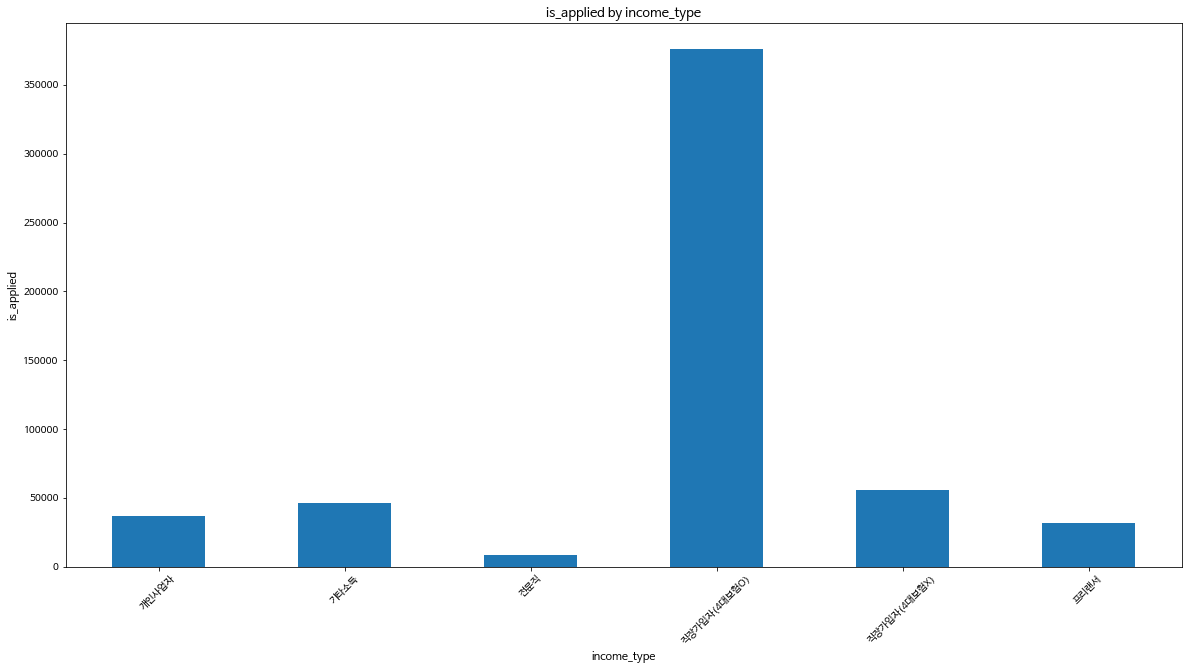

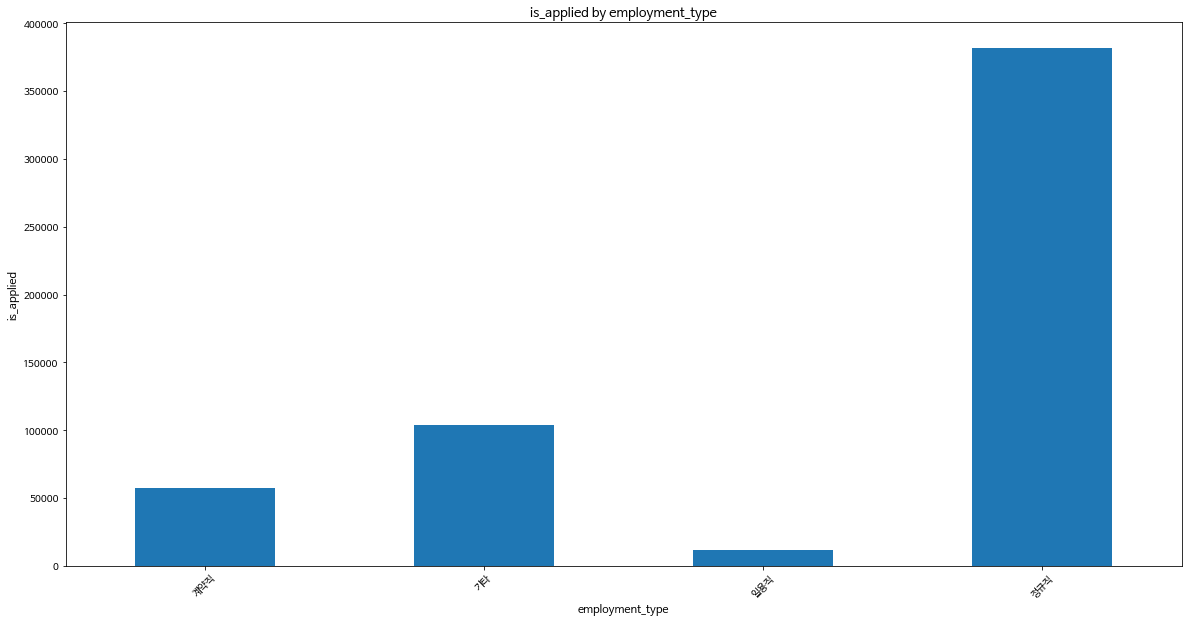

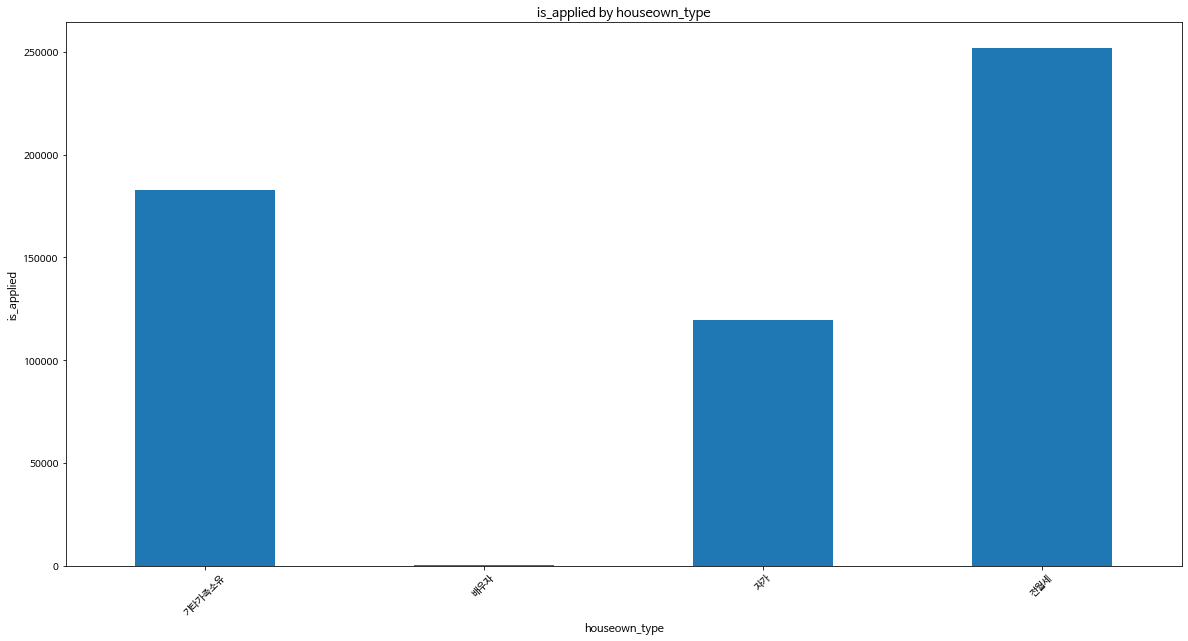

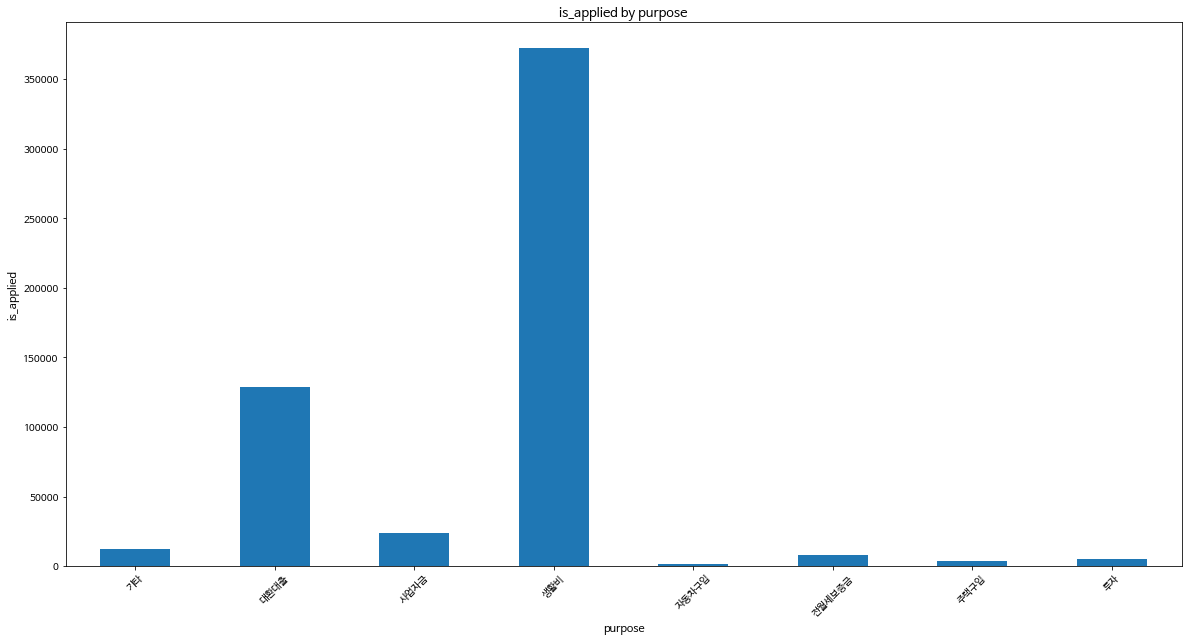

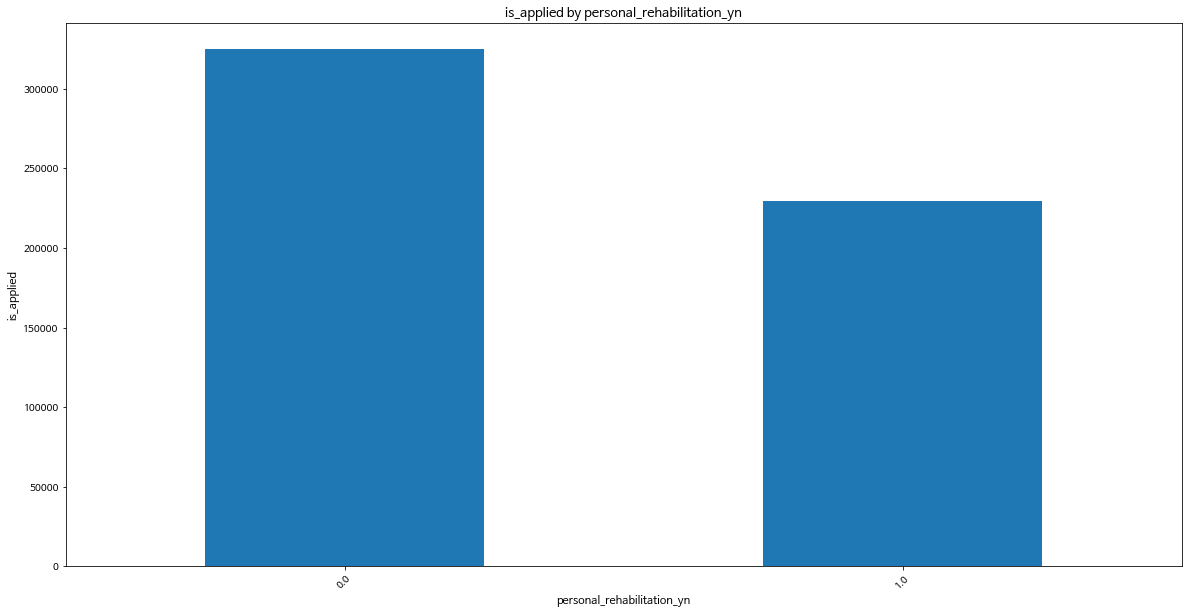

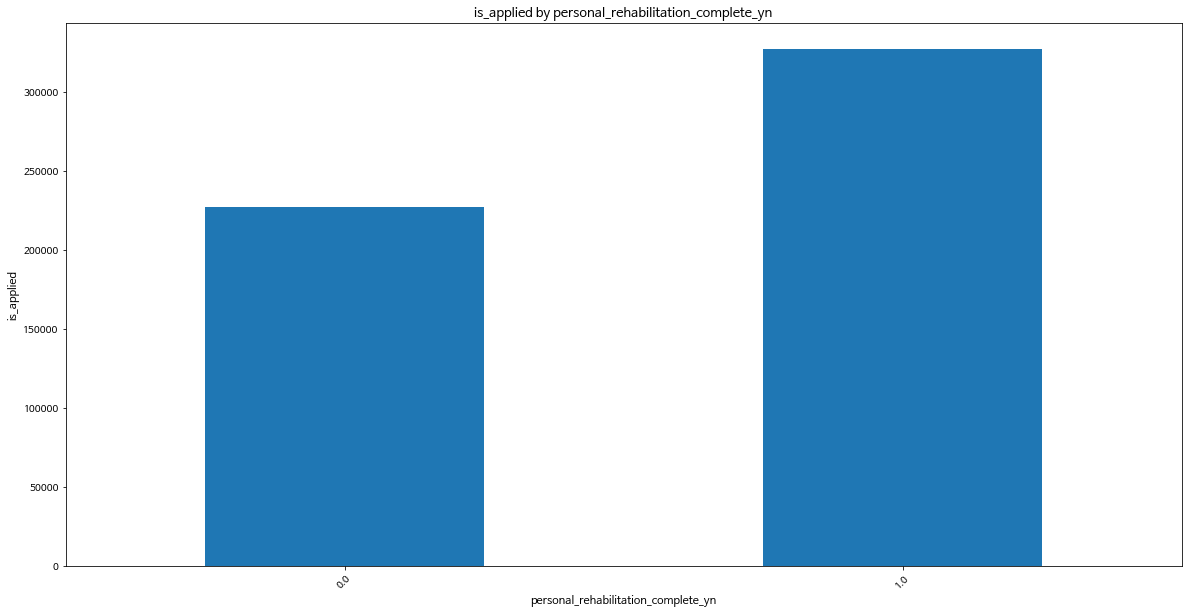

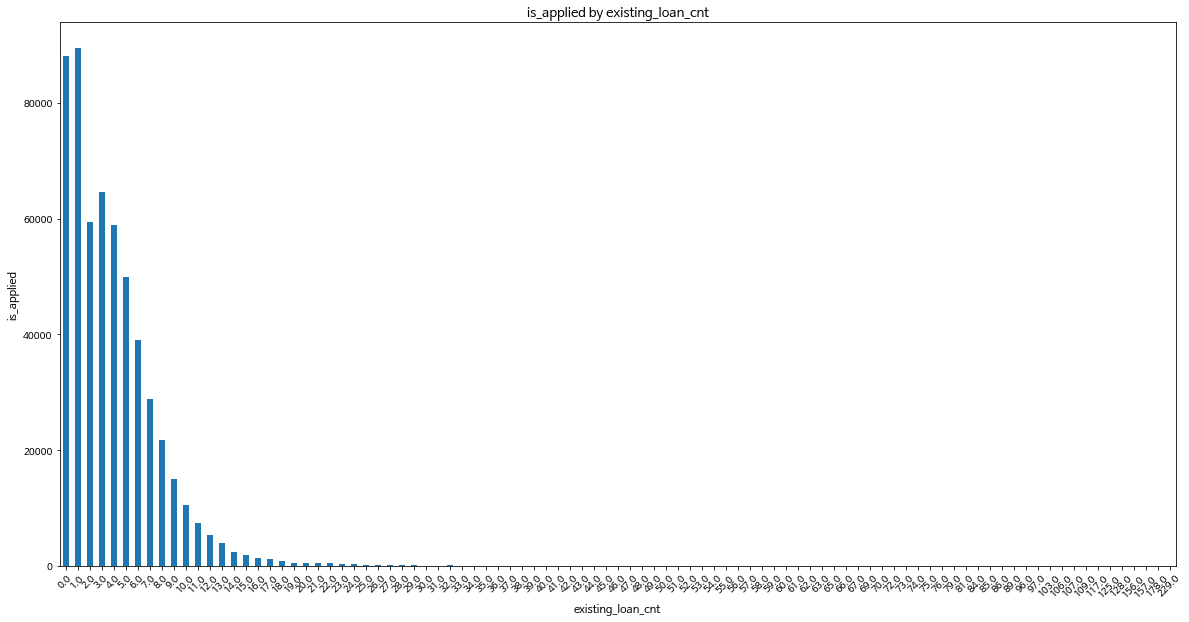

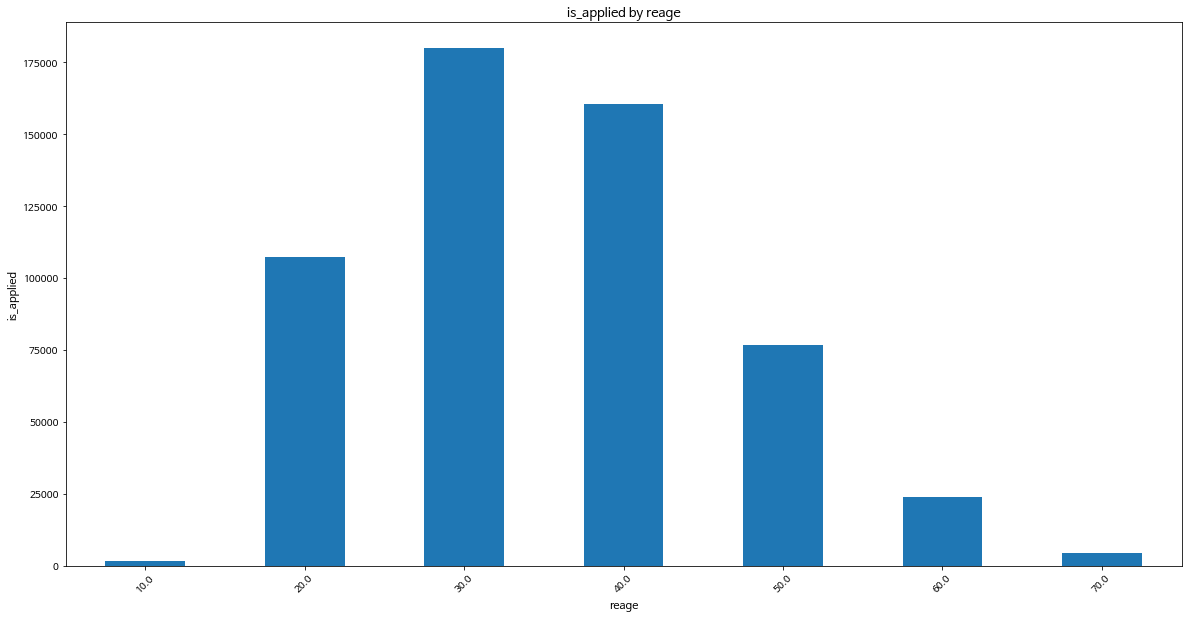

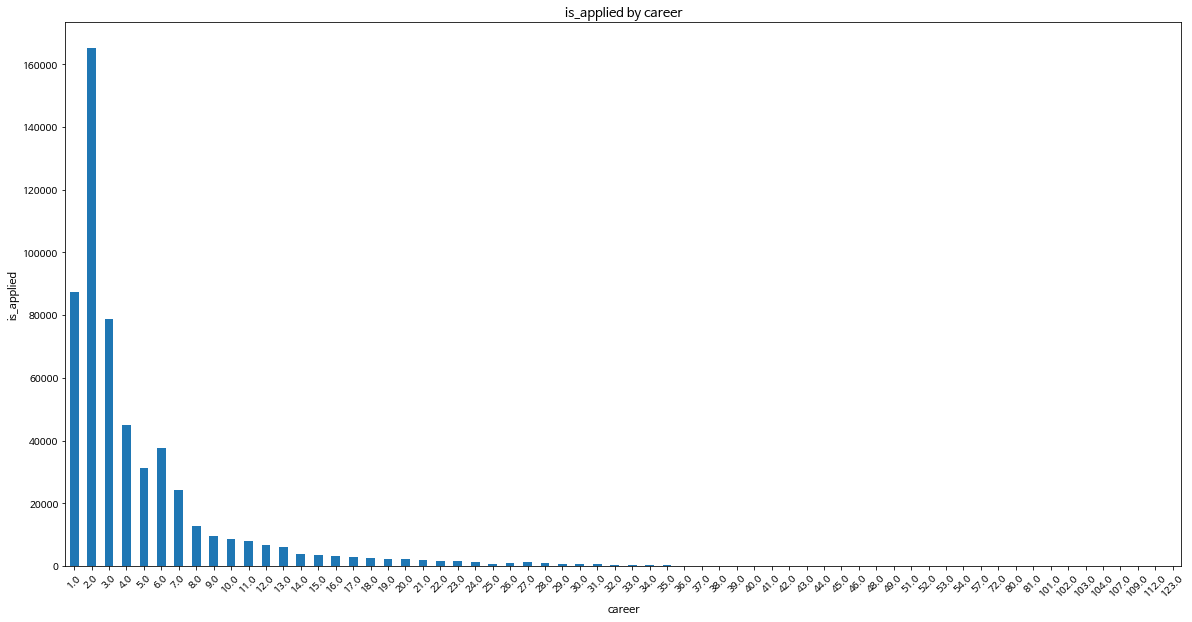

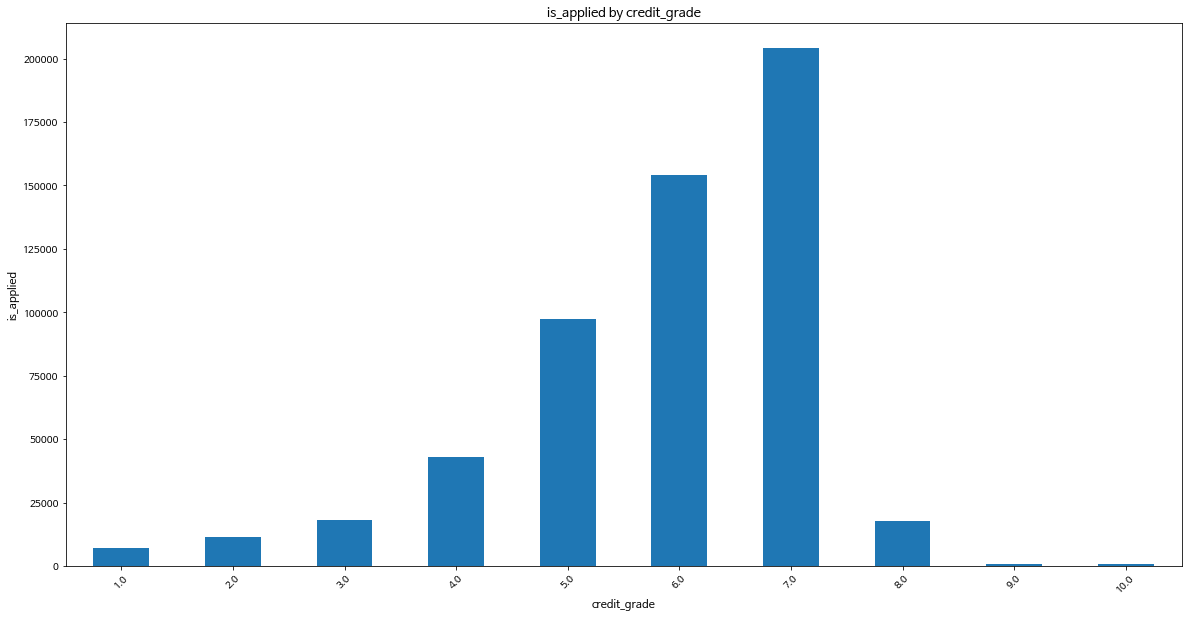

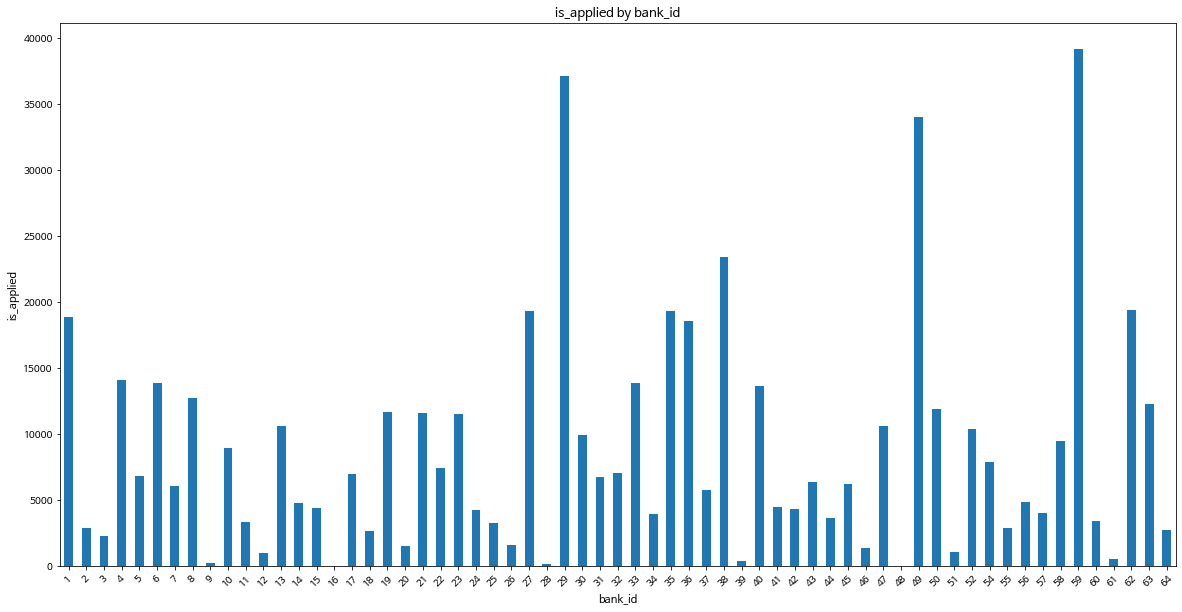

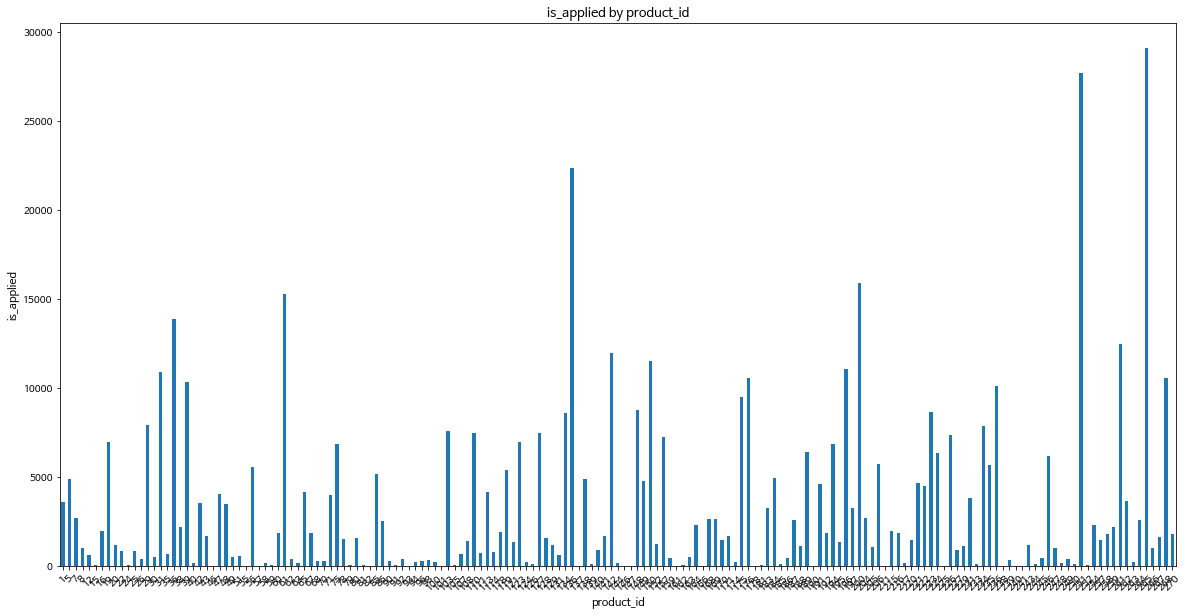

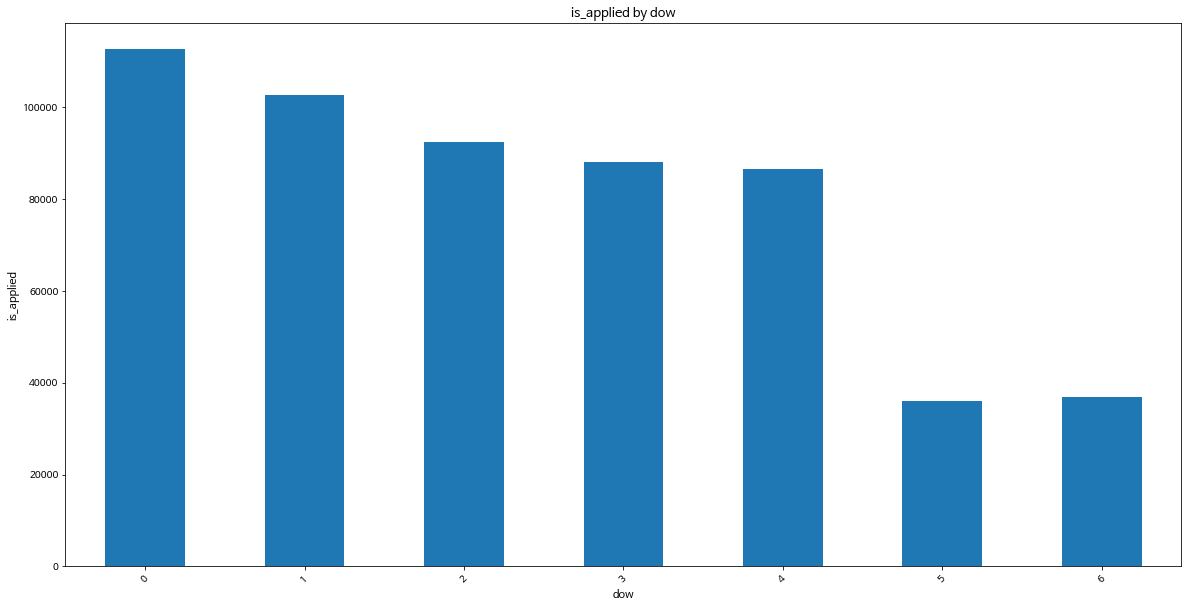

In [10]:
for col in column_list:
  sample = join.groupby(col).sum()['is_applied']
  plot_bar(sample, col, 'is_applied', 'is_applied by ' + col)
  plt.show()

# 4. 월별 대출

In [12]:
def extract_month(date):
    month = str(date.month)
    if date.month < 10:
        month = '0' + month
    return str(date.year) + month 

In [ ]:
join['insert_time'] = pd.to_datetime(join['insert_time'], infer_datetime_format=True)

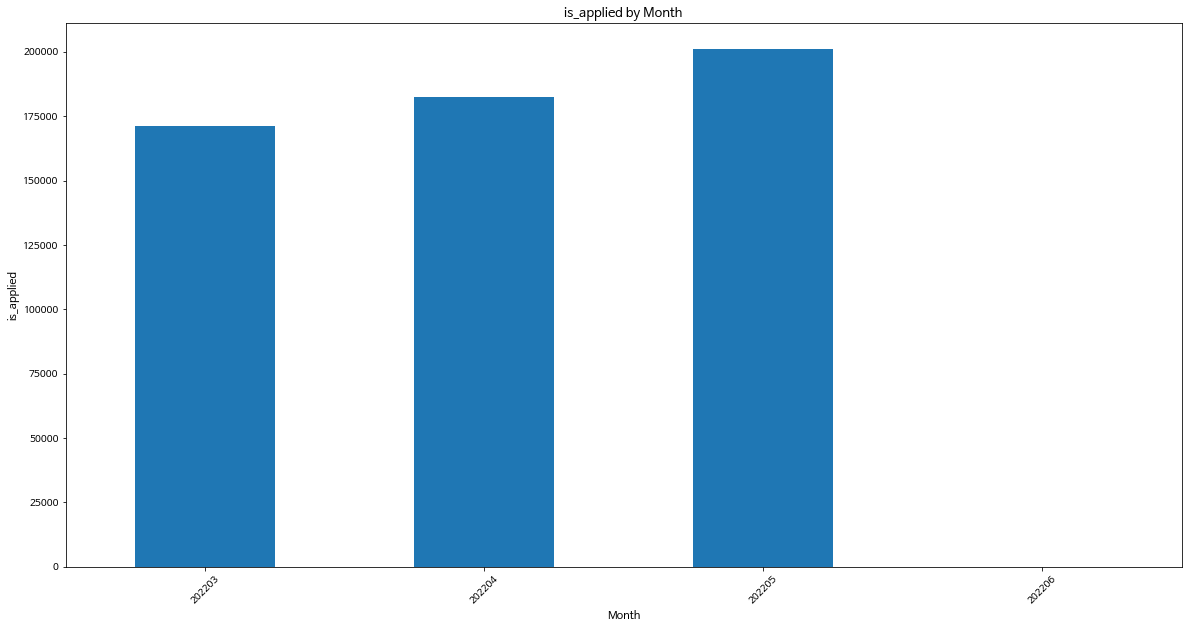

In [15]:
applied_by_month = join.set_index('insert_time').groupby(extract_month).sum()['is_applied']
applied_by_month

plot_bar(applied_by_month, 'Month', 'is_applied', 'is_applied by Month')

# 5. 요일별 대출

In [16]:
applied_by_dow = join.set_index('insert_time').groupby(lambda date:date.dayofweek).sum()['is_applied']
applied_by_dow

insert_time
0    112639.0
1    102532.0
2     92274.0
3     88093.0
4     86414.0
5     35900.0
6     36859.0
Name: is_applied, dtype: float64

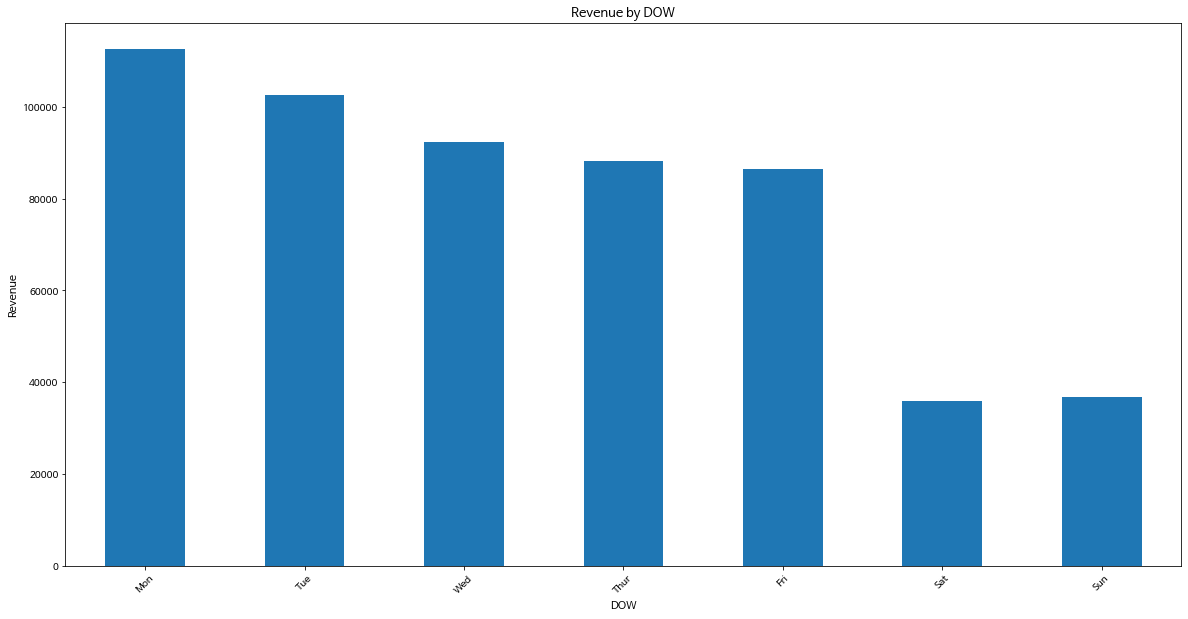

In [17]:
DAY_OF_WEEK = np.array(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
applied_by_dow.index = DAY_OF_WEEK[applied_by_dow.index]
plot_bar(applied_by_dow, 'DOW', 'Revenue', 'Revenue by DOW')

# 6. 시간별 대출

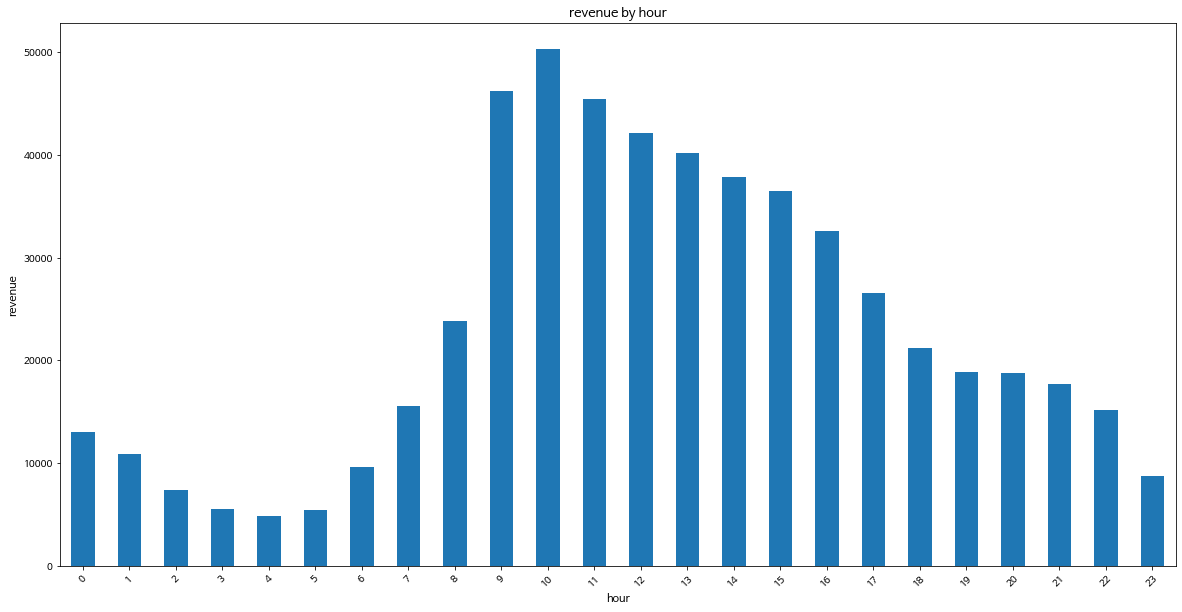

In [18]:
applied_by_hour = join.set_index('insert_time').groupby(lambda date:date.hour).sum()['is_applied']
plot_bar(applied_by_hour, 'hour', 'revenue', 'revenue by hour')

# 7. 상품별 Top5

In [28]:
# 상품별 대출 top5
top_applied = join.groupby('product_id').sum()['is_applied'].sort_values(ascending=False)[:5]
top_applied

product_id
265    29067.0
251    27698.0
136    22367.0
200    15922.0
61     15300.0
Name: is_applied, dtype: float64

In [29]:
# 상품별 금리 top5
top_loan_rate = join.groupby('product_id').sum()['loan_rate'].sort_values(ascending=False)[:5]
top_loan_rate

product_id
29     4127545.5
150    4124879.9
36     3967554.2
56     3890488.1
206    3879355.7
Name: loan_rate, dtype: float64

In [30]:
# 상품별 한도 top5
top_loan_limit = join.groupby('product_id').sum()['loan_limit'].sort_values(ascending=False)[:5]
top_loan_limit

product_id
142    7.949319e+12
65     7.542216e+12
150    7.108418e+12
110    7.011955e+12
149    6.887624e+12
Name: loan_limit, dtype: float64

# 8. top5 상품의 월별 대출량 추이

In [31]:
monthly_top5 = join.set_index('insert_time').groupby(['product_id', extract_month]).sum()[['is_applied']].loc[top_applied.index]

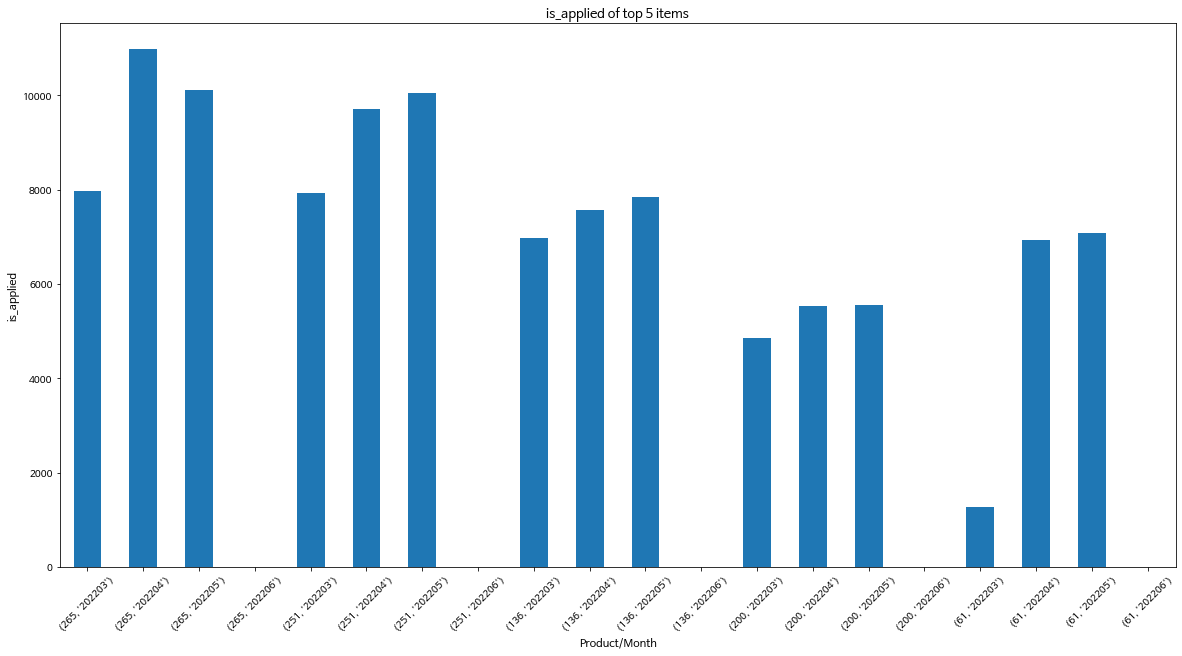

In [32]:
plot_bar(monthly_top5['is_applied'], 'Product/Month', 'is_applied', 'is_applied of top 5 items')

# 9. 사용자 retention 분석
- 월간 사용자 cohort를 바탕으로 월별 재구매율(retention) 분석하기
- heatmap으로 한눈에 재구매율을 파악 가능

In [33]:
join.groupby('user_id').count()['is_applied'].sort_values(ascending=False)

user_id
864179    4493
286813    3764
86932     2987
454280    2828
451656    2758
          ... 
411664       0
237017       0
714204       0
236993       0
416041       0
Name: is_applied, Length: 317458, dtype: int64

## 사용자 기준으로 최초 구매한 월(month) 연산하기
 - Month : 구매월(일(day)을 무시) 
 - MonthStarted: 사용자가 최초 구매한 달

In [38]:
from datetime import datetime

def get_month_as_datetime(date):
    return datetime(date.year, date.month, 1)

In [39]:
join['Month'] = join['insert_time'].apply(get_month_as_datetime)
join.head()

,application_id,user_id,gender,insert_time,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,...,career,credit_grade,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,dow,Month
0,1748340,430982,1.0,2022-06-07 13:05:39,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,...,1.0,7.0,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN,1,2022-06-01
1,1748340,430982,1.0,2022-06-07 13:05:39,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,...,1.0,7.0,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN,1,2022-06-01
2,1748340,430982,1.0,2022-06-07 13:05:39,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,...,1.0,7.0,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN,1,2022-06-01
3,1748340,430982,1.0,2022-06-07 13:05:39,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,...,1.0,7.0,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN,1,2022-06-01
4,1748340,430982,1.0,2022-06-07 13:05:39,24000000.0,직장가입자(4대보험O),정규직,자가,25000000.0,대환대출,...,1.0,7.0,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN,1,2022-06-01


In [40]:
month_group = join.groupby('user_id')['Month']
join['MonthStarted'] = month_group.transform(np.min)

join.tail()

,application_id,user_id,gender,insert_time,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,...,credit_grade,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,dow,Month,MonthStarted
13519863,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,7.0,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN,4,2022-06-01,2022-03-01
13519864,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,7.0,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN,4,2022-06-01,2022-03-01
13519865,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,7.0,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN,4,2022-06-01,2022-03-01
13519866,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,7.0,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN,4,2022-06-01,2022-03-01
13519867,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,7.0,2022-06-03 12:01:48,5,194,44000000.0,9.7,NaN,4,2022-06-01,2022-03-01


## 기준이 되는 월과 실제 구매 월의 차이 계산하기
 - 각 구매가 최초 구매로 부터 얼마의 월이 지났는지 연산
 - MonthPassed : 최초 구매월로부터의 월 차이

In [41]:
join['MonthPassed'] = (join['Month'].dt.year - join['MonthStarted'].dt.year) * 12 + \
    (join['Month'].dt.month - join['MonthStarted'].dt.month)

In [43]:
join.tail()

,application_id,user_id,gender,insert_time,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,...,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,dow,Month,MonthStarted,MonthPassed
13519863,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN,4,2022-06-01,2022-03-01,3
13519864,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN,4,2022-06-01,2022-03-01,3
13519865,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN,4,2022-06-01,2022-03-01,3
13519866,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN,4,2022-06-01,2022-03-01,3
13519867,1428218,478802,1.0,2022-06-03 12:01:47,45000000.0,직장가입자(4대보험O),정규직,기타가족소유,50000000.0,대환대출,...,2022-06-03 12:01:48,5,194,44000000.0,9.7,NaN,4,2022-06-01,2022-03-01,3


## 기준 월, MonthPassed를 기준으로 고객 카운팅
 - 기준이 되는 월과 그 월로부터 지난 기간의 고객 수를 계산

In [44]:
def get_unique_no(x):
    return len(np.unique(x))

In [45]:
cohort_group = join.groupby(['MonthStarted', 'MonthPassed'])
cohort_df = cohort_group['user_id'].apply(get_unique_no).reset_index()
cohort_df.head()

,MonthStarted,MonthPassed,user_id
0,2022-03-01,0,113738
1,2022-03-01,1,39432
2,2022-03-01,2,32664
3,2022-03-01,3,28281
4,2022-04-01,0,77640


## 테이블 피벗
 - pivot 함수를 이용하여 index는 MonthStarted, columns을 MonthPassed로 변경하여 테이블 변경
 - 첫번째 column을 기준으로 100분위 연산

In [46]:
cohort_df = cohort_df.pivot(index='MonthStarted', columns='MonthPassed')
cohort_df.head()

user_id                           
MonthPassed          0        1        2        3
MonthStarted                                     
2022-03-01    113738.0  39432.0  32664.0  28281.0
2022-04-01     77640.0  21037.0  15730.0      NaN
2022-05-01     67943.0  16037.0      NaN      NaN
2022-06-01     58137.0      NaN      NaN      NaN

In [47]:
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100
customer_cohort = customer_cohort.round(decimals=2)

customer_cohort

user_id                     
MonthPassed        0      1      2      3
MonthStarted                             
2022-03-01     100.0  34.67  28.72  24.87
2022-04-01     100.0  27.10  20.26    NaN
2022-05-01     100.0  23.60    NaN    NaN
2022-06-01     100.0    NaN    NaN    NaN

## heatmap 출력하기
 - seaborn의 heatmap 함수로 visualization!

In [51]:
customer_cohort.index.unique()

DatetimeIndex(['2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'], dtype='datetime64[ns]', name='MonthStarted', freq=None)

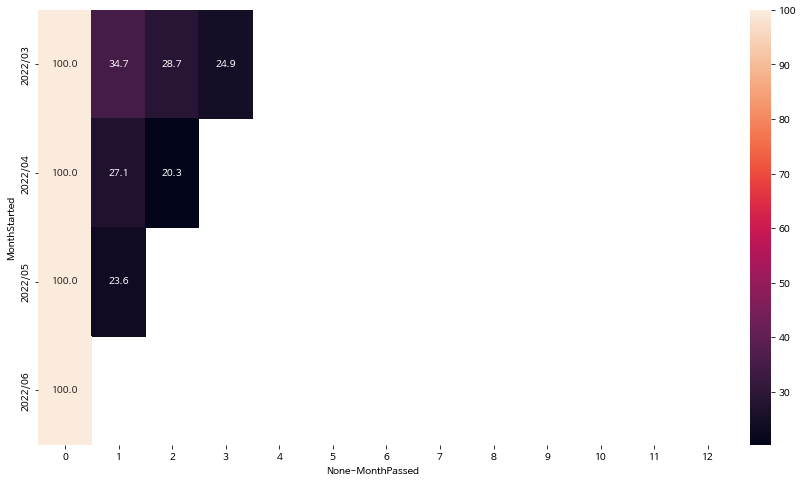

In [52]:
xticks = np.arange(0, 13)
yticks = ['2022/03', '2022/04', '2022/05', '2022/06']

plt.figure(figsize = (15, 8))
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')